# Solving CIFAR-10 using ScRRAMBLe-MLP mixer like architecture

In [2]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import csv
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from datetime import date
import einops

from models import ScRRAMBLeCapsLayer

# from utils.activation_functions import quantized_relu_ste, squash
from utils.loss_functions import margin_loss
from utils import ScRRAMBLe_routing, intercore_connectivity, load_and_augment_mnist, load_cifar10


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = "/local_disk/vikrant/datasets"

In [ ]:
# def load_and_augment_cifar10(
        
# ):

In [4]:
# load cifar10 dataset
dataset_dict = {
    'batch_size': 64, # 64 is a good batch size for CIFAR-10
    'train_steps': 30000, # run for longer, 30000 is good for CIFAR-10
    'binarize': False,  # CIFAR-10 is usually kept as RGB
    'greyscale': False,  # CIFAR-10 is RGB by default
    'data_dir': DATA_PATH,
    'seed': 101,
    'quantize_flag': True,  # whether to quantize the images
    'quantize_bits': 8,  # number of bits to quantize the images
    'num_rotations': 4,  # for every image, rotate it by
    'shuffle_buffer': 1024,  # shuffle buffer size
    }

train_ds, valid_ds, test_ds = load_cifar10(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    augmentation=True,
    num_rotations=dataset_dict['num_rotations'],
)

I0000 00:00:1763511679.675681 3890779 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43591 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


2025-11-18 16:21:21.041334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-18 16:21:21.547084: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


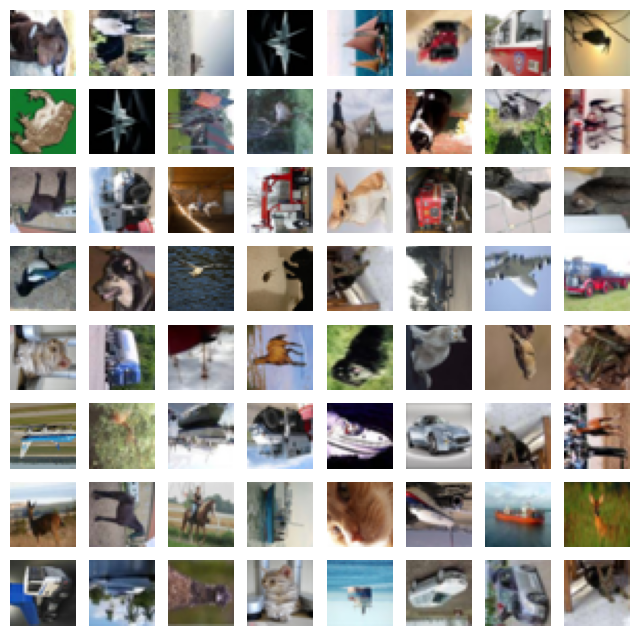

In [5]:
#extract a test image
test_batch = next(iter(test_ds))
train_batch = next(iter(train_ds))
train_images = train_batch['image']
train_labels = train_batch['label']
# test_images = test_batch['image']
# test_labels = test_batch['label']
# test_image = test_images[0]
# test_label = test_labels[0]
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(train_images[i*8 + j])
        ax[i,j].axis('off')

In [6]:
test_images = test_batch['image']
test_labels = test_batch['label']
test_image = test_images[0]
test_label = test_labels[0]

(32, 32, 3)
(1, 4, 4, 16)


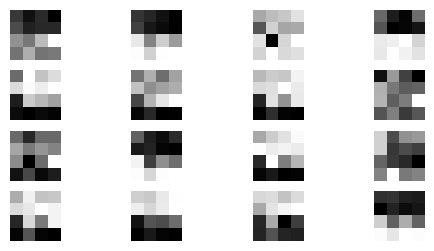

In [7]:
# testing the patch size conv operation
print(test_image.shape)
patch_size = 8
rngs = nnx.Rngs(0)
conv_block = nnx.Conv(in_features=test_image.shape[2], kernel_size=(patch_size, patch_size), strides=(patch_size, patch_size), out_features=16, rngs=rngs)
patches = conv_block(test_image[None, ...])
print(patches.shape)
fig, ax = plt.subplots(4, 4, figsize=(6,3))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(patches[0, :, :, i*4 + j], cmap='gray')
        ax[i,j].axis('off')


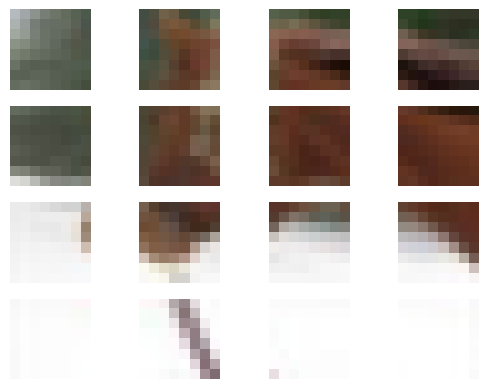

In [8]:
# patching with einops
patches = einops.rearrange(test_image, '(h p1) (w p2) c -> p1 p2 h w c', p1=patch_size, p2=patch_size)
patches = jnp.array(patches)
patches.shape

fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(patches[:, :, i, j, :])
        ax[i,j].axis('off')

In [25]:
## optional convolutional preprocessing block
class ConvPreprocess(nnx.Module):
    """
    Convolutional block as a first stage preprocessing before ScRRAMBLe
    Logic:
    - Add conv + batch norm + relu + maxpooling
    - Flatten the output at the final stage.
    - Project to required number of features using a fixed random matrix.
    """

    def __init__(self,
                 rngs: nnx.Rngs,
                 output_dim: int, # dimension of output. For ScRRAMBLe, typically multiples of num_cores are used.
                 ):
        self.conv1 = nnx.Conv(in_features=3, out_features=64, kernel_size=(3,3), rngs=rngs)
        self.batch_norm1 = nnx.BatchNorm(64, rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=0.1, rngs=rngs)
        self.maxpool1 = partial(nnx.max_pool, window_shape=(2,2), strides=(2,2))

        self.conv2 = nnx.Conv(in_features=64, out_features=128, kernel_size=(3,3), rngs=rngs)
        self.batch_norm2 = nnx.BatchNorm(128, rngs=rngs)
        
        initializer = initializers.glorot_normal()
        self.M = nnx.Variable(
            initializer(rngs.params(), (output_dim, 32768))
        )


    def __call__(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = nnx.relu(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        x = nnx.relu(x)
        x = self.dropout1(x)

        x = x.flatten()  # flatten

        # transform
        x = jnp.einsum('ij, j -> i', self.M.value, x)
        return x


In [26]:
# testing
text_conv_preprocess = ConvPreprocess(nnx.Rngs(0), output_dim=2048)
conv_output = text_conv_preprocess(test_image[None, ...])
print(conv_output.shape)  # should be (1, output_dim)


(2048,)


In [ ]:
# ScRRAMBLe Layer that can deal with patches directly
class ScRRAMBLePatchLayer(nnx.Module):
    """
    ScRRAMBLe Layer that can operate on image patches.
    Terminologies:
    h: no. of patches in the hieght dimension.
    w: no. of patches in the width dimension.
    p1: patch size in height dimension
    p2: patch size in width dimension
    c: channels 
    Logic:
    - Take an input image (HxWxC) (e.g. 32x32x3 for CIFAR10)
    - Convert the image into patches of shape (h, w, p1, p2, c)
    - Use ScRRAMBLe routing to route the patches to the cores.
    - Flatten the patches going to every slot.
    - Compute MVM at every core.
    - Apply non-linearity to the output of every core.
    - Output will be of shape (num_cores, core_size).

    Args:
    - num_cores: Number of cores in the ScRRAMBLe layer.
    - h: number of patches in height dimension.
    - w: number of patches in width dimension.
    - p1: patch size in height dimension.
    - p2: patch size in width dimension.
    - c: number of channels in the input image.

    """

    def __init__(self,
                 ):


In [ ]:
# ScRRAMBLe-MLP class pilot
class ScRRAMBLeMLPMix(nnx.Module):
    """
    Experimental ScRRAMBLe-MLP class that leverages MLP-Mixer style ScRRAMBLe topology.
    Terminologies:
    h: no. of patches in the hieght dimension.
    w: no. of patches in the width dimension.
    p1: patch size in height dimension
    p2: patch size in width dimension
    c: channels 
    Logic:
    - Convert an input image of shape (H, W, c) to patches of shape (h*p1, w*p2, c)
    - Reshape to (p1, p2, h, w, c)
    - Expect the input to be of shape (p1, p2, h, w, c)
    - Unroll the patches channel-wise to get c no. of p1*p2*h*w patches.
    - Feed each patch into a receptive-field/slot of a ScRRAMBLe Layer.
    - Add skip connections and LayerNorm operations.

    Args:
    - layer_sizes: list; of layer sizes in terms of number of cores/capsules
    - capsule_size: int; size of each core/capsule (e.g. 256)
    - receptive_field_size: int; size of receptive field (e.g. 64 for 8x8 patches)
    - connection_probabilities: list; of connection probabilities between layers
    - rngs: nnx.Rngs; rng stream
    """

    def __init__(self,
                 layer_sizes: list,
                 receptive_field_size: int,
                 rngs: nnx.Rngs,
                 connection_probabilities: list,
                 activation_function: Callable,
                 capsule_size: int,
                 input_shape: tuple,
                 ):
        
        (self.p1, self.p2, self.h, self.w, self.c) = input_shape # extract the shape dimensions
        


        

    